In [13]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from simple_transformer import Transformer
from dataset import StreaksDataset
import torch
from src import utils

In [13]:

model = Transformer()
model.eval()
batch_size = 8
inputs = torch.randn(batch_size, 512, 32)
numeric_features = torch.rand(batch_size,5)
mask = torch.ones(batch_size, 512, dtype=torch.bool)
mask[:, 256:] = 0
outputs = model(inputs, numeric_features, mask)
print(outputs.shape)
print(outputs)

NameError: name 'torch' is not defined

In [117]:

# Print the number of parameters
num_params = sum(p.numel() for p in model.parameters())

In [118]:
print(num_params)

125633


In [17]:

# load all images
# images_train = 
# 
# train_dataset = StreaksDataset(


AttributeError: module 'datasets' has no attribute 'split_data'

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
train=0.8
val=0.1
test=0.1
seed=1104

# Load the data
good_data = pd.read_csv(os.path.join(utils.get_project_root(), 'good_data.csv'))
numerical_data_df = pd.read_csv(os.path.join(utils.get_project_root(), 'datasets/auxiliary_data.csv'))
targets_df = pd.read_csv(os.path.join(utils.get_project_root(), 'datasets/targets.csv'))
# Split data by filenames
file_names = good_data['file_name'].unique()
file_names_temp, file_names_test = train_test_split(file_names, train_size=train+val, random_state=seed)
file_names_train, file_names_val = train_test_split(file_names_temp, train_size=train/(train+val), random_state=seed + 1)
 
train_data = good_data[good_data['file_name'].isin(file_names_train)]
val_data = good_data[good_data['file_name'].isin(file_names_val)]
test_data = good_data[good_data['file_name'].isin(file_names_test)]

def get_data(data):
    images = [
        torch.tensor(np.load(utils.get_strip_file_path(row)), dtype=torch.float) for (_, row) in data.iterrows()
    ]
    numeric = torch.tensor(
        pd.merge(data, numerical_data_df, on='file_name')[numerical_data_df.columns].drop(columns=['file_name']).to_numpy()
    )
    targets = torch.tensor(
        pd.merge(data.drop(columns=['ang_vel[deg/s]']), targets_df, on=['file_name', 'extension', 'ID'])['ang_vel[deg/s]'].to_numpy()
    )
    return images, numeric, targets

print(get_data(train_data)[0][0].shape)

train_dataset = StreaksDataset(*get_data(train_data))

val_dataset = StreaksDataset(*get_data(val_data), 
                             images_mean=train_dataset.images_mean,
                             images_std=train_dataset.images_std,
                             numeric_features_mean=train_dataset.numeric_features_mean,
                             numeric_features_std=train_dataset.numeric_features_std,
                             targets_mean=train_dataset.targets_mean,
                             targets_std=train_dataset.targets_std)
test_dataset = StreaksDataset( *get_data(test_data),
                               images_mean=train_dataset.images_mean,
                               images_std=train_dataset.images_std,
                               numeric_features_mean=train_dataset.numeric_features_mean,
                               numeric_features_std=train_dataset.numeric_features_std,
                               targets_mean=train_dataset.targets_mean,
                               targets_std=train_dataset.targets_std)
train_dataset.__getitem__(1)[0].shape




In [3]:
from train import train

train()


Epoch 1/10 - Training:   0%|          | 0/59 [00:00<?, ?it/s]

Numeric features shape:  torch.Size([16, 7])


KeyboardInterrupt: 

In [10]:
from transformer_artifical_data import artificial_transformer

import torch

model = artificial_transformer.Transformer()


data = torch.rand(8,200,32)
targets = torch.randn(8,1)
mask = torch.zeros(8, 200, dtype=torch.bool)

model.forward(data, mask)



tensor([[0.0806],
        [0.0806],
        [0.0806],
        [0.0806],
        [0.0806],
        [0.0806],
        [0.0806],
        [0.0806]], grad_fn=<AddmmBackward0>)

Start of train()
Data loaders initialized
Created new model
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.0066


Epoch 1/1 - Validation:   0%|          | 0/1 [00:00<?, ?it/s]/home/dofri/epfl/semester_project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation Loss: 1.1202, Validation Mean Error: -0.6873 
Validation loss improved to 1.1202. Saving model.
Loaded best model based on validation loss.


Test Loss: 1.8209
Training complete!
Correlation between True Frequency and MSE: 0.6354, p-value: 4.8362e-02
Correlation between Width and MSE: -0.5784, p-value: 7.9843e-02
Mean squared error: 2.3195, Mean error: -0.9302, Mean absolute error: 1.3463


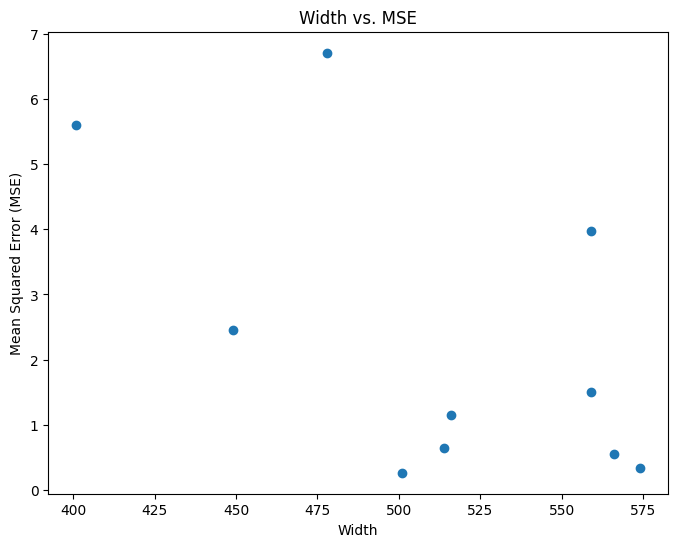

In [12]:
from transformer_artifical_data import artificial_dataset
from src.analysis.artificial_model_analysis import evaluate_model
from src.analysis.artificial_model_analysis import analyze_results
from src.models.transformer_artifical_data import artificial_train

# Dummy test dataset
datasets, dfs = artificial_dataset.split_data_into_datasets(train=.333, val=.333, test=.333, no_samples=30)
# model = artificial_transformer.Transformer()

model, optimizer, trainin_losses, validation_losses, test_loss = artificial_train.train(1, datasets['train'], datasets['val'], datasets['test'])

eval_df = evaluate_model(model, datasets['test'], dfs['test'])
analyze_results(eval_df)




Start of train()
Data loaders initialized
Using existing model
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.0615


Validation Loss: 0.9148, Validation Mean Error: -0.5174 
Validation loss improved to 0.9148. Saving model.
Loaded best model based on validation loss.


Test Loss: 1.6271
Training complete!
Correlation between True Frequency and MSE: 0.7003, p-value: 2.4112e-02
Correlation between Width and MSE: -0.5676, p-value: 8.7000e-02
Mean squared error: 2.5922, Mean error: -1.0772, Mean absolute error: 1.4294


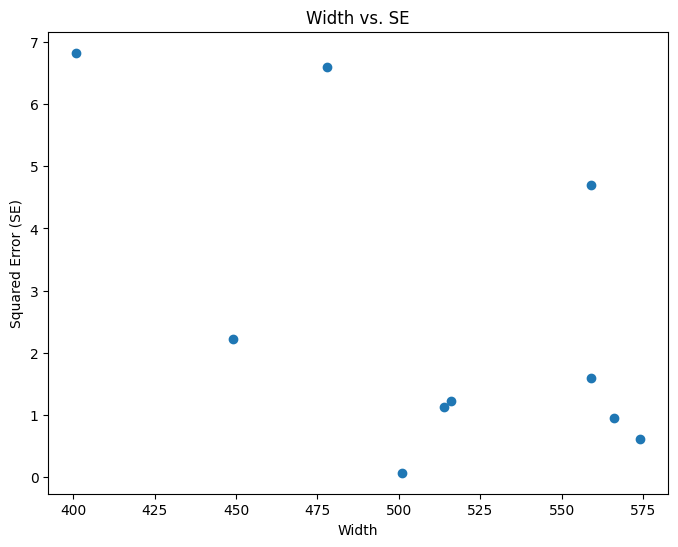

In [15]:
from src.models.transformer_artifical_data.artificial_transformer_cls import TransformerWCLS
from src.models.transformer_artifical_data.artificial_transformer_bad_pooling import TransformerBadPool
# Dummy test dataset
datasets, dfs = artificial_dataset.split_data_into_datasets(train=.333, val=.333, test=.333, no_samples=30)
model = TransformerBadPool()

model, optimizer, trainin_losses, validation_losses, test_loss = artificial_train.train(1, datasets['train'], datasets['val'], datasets['test'], model=model)

eval_df = evaluate_model(model, datasets['test'], dfs['test'])
analyze_results(eval_df)





In [7]:
# import zipfile
# import os
# from src import utils
# zip_path = os.path.join(utils.get_project_root(), 'src','datasets','artificial_strips.zip')
# extract_to = os.path.join(utils.get_project_root(), 'src', 'datasets')
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)
#     print(f"Unzipped {zip_path} to {extract_to}")

Unzipped /home/dofri/epfl/semester_project/src/datasets/artificial_strips.zip to /home/dofri/epfl/semester_project/src/datasets


In [55]:
from src.models.cnn.simple_cnn import SimpleCNN 
from src.models.transformer_artifical_data import artificial_transformer 
cnn_model = SimpleCNN()
transformer_model =  artificial_transformer.Transformer()



# print model number of parameters
num_params_cnn = sum(p.numel() for p in cnn_model.parameters())
num_params_transformer = sum(p.numel() for p in transformer_model.parameters())
print(num_params_cnn)
print(num_params_transformer)

2542977
607361


Start of train()
Data loaders initialized
Created new model
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 0.8990


Validation Loss: 1.8312, Validation Mean Error: -0.3942 
Validation loss improved to 1.8312. Saving model.
Loaded best model based on validation loss.


/home/dofri/epfl/semester_project/src/analysis/artificial_model_analysis.py:147: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  width_mse_corr, width_mse_pval = pearsonr(widths, mses)


Test Loss: 2.1701
Training complete!
Correlation between True Frequency and MSE: 0.6610, p-value: 3.7419e-02
Correlation between Width and MSE: nan, p-value: nan
Mean squared error: 1.9570, Mean error: -0.2539, Mean absolute error: 1.0868


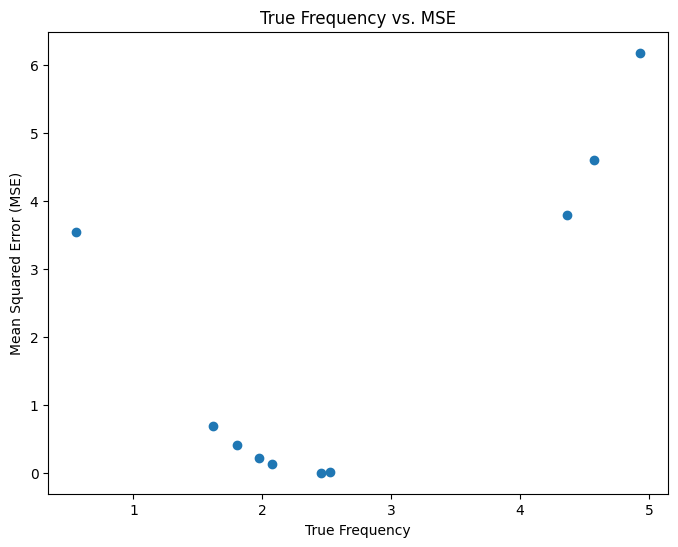

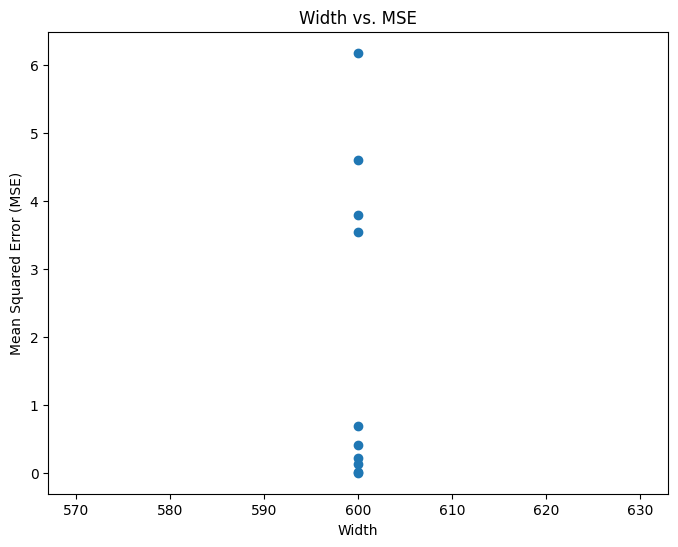

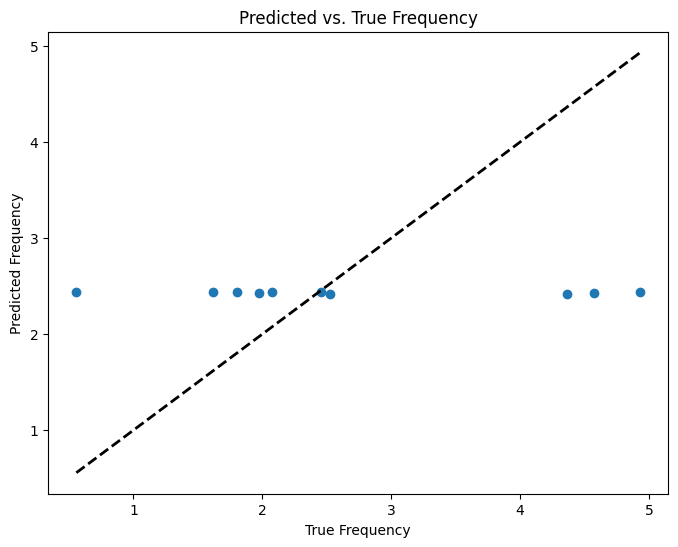

In [112]:
from src.models.cnn import cnn_train 
from transformer_artifical_data import artificial_dataset
from src.analysis.artificial_model_analysis import evaluate_model
from src.analysis.artificial_model_analysis import analyze_results

# Dummy test dataset
datasets, dfs = artificial_dataset.split_data_into_datasets(train=.333, val=.333, test=.333, no_samples=30, data_path=utils.path_from_proot('src/datasets/artificial_strips/w600px'))
# model = artificial_transformer.Transformer()

model, optimizer, trainin_losses, validation_losses, test_loss = cnn_train.train(1, datasets['train'], datasets['val'], datasets['test'])


eval_df = evaluate_model(model, datasets['test'], dfs['test'], masked_model=False)
analyze_results(eval_df)

 

In [36]:
from src.models.transformer_artifical_data.artificial_dataset_fixed_width import ArtificialStreaksDatasetWithFixedWidth
from src.models.transformer_artifical_data import artificial_dataset_fixed_width

# Try data loader with random starts
width = 500
datasets, dfs = artificial_dataset_fixed_width.split_data_into_datasets(min_width=width, no_samples=40)
print (len(datasets['train']))
print(len(datasets['val']))
print(len(datasets['test']))


32
4
4


In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(datasets['train'], batch_size=8, shuffle=True)
val_loader = DataLoader(datasets['val'], batch_size=2, shuffle=True)
test_loader = DataLoader(datasets['test'], batch_size=1, shuffle=True)

# Check widths of images from the dataloaders
for i, (images, targets) in enumerate(train_loader):
    print(images.shape)
    print(targets.shape)

print()
for i, (images, targets) in enumerate(val_loader):
    print(images.shape)
    print(targets.shape)

print()    
for i, (images, targets) in enumerate(test_loader):
    print(images.shape)
    print(targets.shape)

NameError: name 'datasets' is not defined

In [47]:

from src.models import dataset
from torch.utils.data import DataLoader


datasets, dataframes = dataset.split_data_into_datasets(min_width=500, no_samples=40, split_on_files=False)
print (len(datasets['train']))
print(len(datasets['val']))
print(len(datasets['test']))
tr_train_loader = DataLoader(datasets['train'], batch_size=8, shuffle=True, collate_fn=dataset.collate_fn_w_maks)
tr_val_loader = DataLoader(datasets['val'], batch_size=2, shuffle=True, collate_fn=dataset.collate_fn_wo_maks)
tr_test_loader = DataLoader(datasets['test'], batch_size=1, shuffle=True, collate_fn=dataset.collate_fn_wo_maks)


# Check widths of images from the dataloaders
for i, (images, mask, numeric, targets) in enumerate(train_loader):
    print('images.shape ', images.shape)
    print('numeric.shape', numeric.shape)
    print('targets.shape', targets.shape)

print()
for i, (images, mask, numeric, targets) in enumerate(val_loader):
    print('images.shape ', images.shape)
    print('numeric.shape', numeric.shape)
    print('targets.shape', targets.shape)

print()
for i, (images, mask, numeric, targets) in enumerate(test_loader):
    print(i)
    print('images.shape ', images.shape)
    print('numeric.shape', numeric.shape)
    print('targets.shape', targets.shape)
    

32
4
4
images.shape  torch.Size([8, 500, 32])
numeric.shape torch.Size([8, 7])
targets.shape torch.Size([8])
images.shape  torch.Size([8, 500, 32])
numeric.shape torch.Size([8, 7])
targets.shape torch.Size([8])
images.shape  torch.Size([8, 500, 32])
numeric.shape torch.Size([8, 7])
targets.shape torch.Size([8])
images.shape  torch.Size([8, 500, 32])
numeric.shape torch.Size([8, 7])
targets.shape torch.Size([8])

images.shape  torch.Size([2, 500, 32])
numeric.shape torch.Size([2, 7])
targets.shape torch.Size([2])
images.shape  torch.Size([2, 500, 32])
numeric.shape torch.Size([2, 7])
targets.shape torch.Size([2])

0
images.shape  torch.Size([1, 500, 32])
numeric.shape torch.Size([1, 7])
targets.shape torch.Size([1])
1
images.shape  torch.Size([1, 500, 32])
numeric.shape torch.Size([1, 7])
targets.shape torch.Size([1])
2
images.shape  torch.Size([1, 500, 32])
numeric.shape torch.Size([1, 7])
targets.shape torch.Size([1])
3
images.shape  torch.Size([1, 500, 32])
numeric.shape torch.Size([

In [57]:
from src.models import simple_transformer
from src.models import train

tr_model, tr_optimizer, tr_train_losses, tr_val_losses, tr_test_loss = train.train(1, datasets['train'], datasets['val'], datasets['test'])

Start of train()
Data loaders initialized
Created new model
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 0.7772


Validation Loss: 1.1522, Validation Mean Error: 0.305 
Validation loss improved to 1.1522. Saving model.
Loaded best model based on validation loss.


Test Loss: 1.2562
Training complete!


In [54]:
from src.models.cnn import cnn_train_w_numerics

datasets, dataframes = dataset.split_data_into_datasets(min_width=500, no_samples=40, split_on_files=False)
cnn_model, cnn_optimizer, cnn_train_losses, cnn_val_losses, cnn_test_loss = cnn_train_w_numerics.train(1, datasets['train'], datasets['val'], datasets['test'])

Start of train()
Data loaders initialized
Created new model
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 0.9726


Validation Loss: 1.8577, Validation Mean Error: 0.2422 
Validation loss improved to 1.8577. Saving model.
Loaded best model based on validation loss.


Test Loss: 1.9425
Training complete!


In [58]:
# print model size
num_params_cnn = sum(p.numel() for p in cnn_model.parameters())
num_params_transformer = sum(p.numel() for p in tr_model.parameters())
print(num_params_cnn)
print(num_params_transformer)

500001
724737


In [9]:
# Test artificial dataset with synthetic_32
from src.models.transformer_artifical_data import artificial_dataset_fixed_width
datasets, dfs = artificial_dataset_fixed_width.split_data_into_datasets_synthetic_32()

In [10]:
from src.models.transformer_artifical_data import artificial_train
model, optimizer, trainin_losses, validation_losses, test_loss = artificial_train.train(1, datasets['train'], datasets['val'], datasets['test'])

Start of train()
Data loaders initialized
Created new model


/home/dofri/epfl/semester_project/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.0132


Epoch 1/1 - Validation:   0%|          | 0/32 [00:00<?, ?it/s]/home/dofri/epfl/semester_project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation Loss: 1.0535, Validation Mean Error: 0.06969 
Validation loss improved to 1.0535. Saving model.
Loaded best model based on validation loss.


Test Loss: 1.0719
Training complete!


In [69]:
# Test new base dataset with different models and datasets.
from src.models.base_dataset import split_data_into_datasets_strips_171124_lc 
from src.models.base_dataset import split_data_into_datasets_synthetic_32 
from src.models.simple_transformer import Transformer as NumericTransformer
from src.models.cnn.simple_cnn import SimpleCNN
from src.models.cnn.simple_cnn_w_numerics import SimpleCNNWithNumerics
from src.models.transformer_artifical_data.artificial_transformer import Transformer as SimpleTransformer
from src.models.transformer_artifical_data.artificial_transformer_cls import TransformerWCLS as SimpleTransformerCLS
from src.models.transformer_artifical_data.artificial_transformer_bad_pooling import TransformerBadPool as SimpleTransformerBadPool
from src.models.train import train 
simple_cnn = SimpleCNN()
numeric_cnn = SimpleCNNWithNumerics()
numeric_transformer = NumericTransformer()
simple_transformer = SimpleTransformer()
simple_transformer_cls = SimpleTransformerCLS()
simple_transformer_bad_pool = SimpleTransformerBadPool()

models = [simple_cnn, numeric_cnn, numeric_transformer, simple_transformer, simple_transformer_cls, simple_transformer_bad_pool]
numeric_models = [
    numeric_transformer, 
    numeric_cnn ]
non_numeric_models = [simple_cnn, simple_transformer, simple_transformer_cls, simple_transformer_bad_pool]
# numerical_columns=(
#     'IRSKY_TEMP', 'TEMP', 'WINDSP', 'PRES', 'FWHM', 'RHUM')#, 'TAU0')
true_dataset, true_dfs = split_data_into_datasets_strips_171124_lc(no_samples=40)
synthetic_dataset, synthetic_dfs = split_data_into_datasets_synthetic_32(no_samples=40)

for model in numeric_models:
    train(1, true_dataset['train'], true_dataset['val'], true_dataset['test'], model)

for model in non_numeric_models:
    train(1, synthetic_dataset['train'], synthetic_dataset['val'], synthetic_dataset['test'], model)



Train: 30 samples, Val: 1 samples, Test: 9 samples
Train: 32 samples, Val: 4 samples, Test: 4 samples
Start of train()
Training model: {'name': 'TransformerWNumerics', 'description': 'Basic transformer with with numeric inputs.', 'input_requires_mask': True, 'input_requires_numerics': True, 'supports_variable_sequence_length': True}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 0.7343


Epoch 1/1 - Validation:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.47]   

Validation Loss: 13.5078, Validation Mean Error: -0.4182 
Validation loss improved to 13.5078. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/9 [00:00<?, ?it/s, loss=0.548]
                                                                        
                                                         

Test Loss: 1.5140
Training complete!
Start of train()
Training model: {'name': 'CNNWNumeric', 'description': 'Basic CNN with numeric data integration', 'input_requires_mask': False, 'input_requires_numerics': True, 'supports_variable_sequence_length': False}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 0.9135


Epoch 1/1 - Validation:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.375] 

Validation Loss: 23.1827, Validation Mean Error: -1.824 
Validation loss improved to 23.1827. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/9 [00:00<?, ?it/s, loss=1.26] 
                                                                         
                                                           

Test Loss: 2.5680
Training complete!
Start of train()
Training model: {'name': 'CNNNoNumeric', 'description': 'Basic CNN', 'input_requires_mask': False, 'input_requires_numerics': False, 'supports_variable_sequence_length': False}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.0297


Epoch 1/1 - Validation:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.55]   

Validation Loss: 7.7946, Validation Mean Error: -0.604 
Validation loss improved to 7.7946. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/4 [00:00<?, ?it/s, loss=7.89e-5]
                                                                        
                                                         

Test Loss: 7.7948
Training complete!
Start of train()
Training model: {'name': 'TransformerNoNumeric', 'description': 'Basic transformer w. masked input.', 'input_requires_mask': True, 'input_requires_numerics': False, 'supports_variable_sequence_length': True}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.1491


Epoch 1/1 - Validation:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.788]  

Validation Loss: 7.7393, Validation Mean Error: -0.03578 
Validation loss improved to 7.7393. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/4 [00:00<?, ?it/s, loss=1.84]
                                                                         
                                                         

Test Loss: 7.7371
Training complete!
Start of train()
Training model: {'name': 'TransformerNoNumericCLSToken', 'description': 'Basic transformer with CLS output token.', 'input_requires_mask': True, 'input_requires_numerics': False, 'supports_variable_sequence_length': True}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.1276


Epoch 1/1 - Validation:   0%|          | 0/4 [00:00<?, ?it/s, loss=1.52]    

Validation Loss: 7.7498, Validation Mean Error: 0.06595 
Validation loss improved to 7.7498. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/4 [00:00<?, ?it/s, loss=2.69]
                                                                        
                                                         

Test Loss: 7.7255
Training complete!
Start of train()
Training model: {'name': 'TransformerNoNumericBadPooling', 'description': 'Basic transformer w. masked input. No masked pooling', 'input_requires_mask': True, 'input_requires_numerics': False, 'supports_variable_sequence_length': True}
Data loaders initialized
Created new optimizer
Starting training


Epoch [1/1], Training Loss: 1.0552


Epoch 1/1 - Validation:   0%|          | 0/4 [00:00<?, ?it/s, loss=1.81]    

Validation Loss: 7.7454, Validation Mean Error: 0.1008 
Validation loss improved to 7.7454. Saving model.
Loaded best model based on validation loss.



Testing:   0%|          | 0/4 [00:00<?, ?it/s, loss=1.91]
                                                                        
                                                            

Test Loss: 7.7406
Training complete!
